In [1]:
import torch
import os
import torchvision
import numpy
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from torchvision import datasets, transforms, models
import resnet50
import model_inception_v3
from sklearn.metrics import f1_score
#resnet_1 = 'model_resnet/first_model_resnet_adam.pt'            #Adams lr=0.03
#resnet_2 ='model_resnet/Rsecond_resnet_model_10_epochs_SGD.pt'  #SGD lr=0.03
#inception ='inception_v3_/Inception_v3_part1_2_epochs.pt'       # RMSProp 
basic_CNN ='model_basic_conv/basic_convolutional.pt'
Path_model = basic_CNN


In [3]:
#import model resnet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = resnet50.Resnet_model()
#model = model.model

#import model inception v3
#model = model_inception_v3.InceptionV3()
#model = model.model

#import cnn model
class CNN_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Conv2d(3,6,5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(3,3),
            torch.nn.Conv2d(6,5,5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(3,3),
            torch.nn.Conv2d(5,5,5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(3,3),
            torch.nn.Flatten(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(180,500),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25),
            torch.nn.Linear(500,120),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(120,20),
            torch.nn.ReLU(),
            torch.nn.Linear(20,3),
            #torch.nn.LogSoftmax(dim=1)
        )
    def forward(self, X):
        return self.layers(X)
model = CNN_model()


In [4]:
#model = torch.load(Path_model, map_location=torch.device('cpu')) # for resnet_1 as I saved whole model

In [5]:
model.load_state_dict(torch.load(Path_model, map_location=torch.device('cpu'))) #  for resnet_2 as I saved state_dict model

RuntimeError: Error(s) in loading state_dict for CNN_model:
	Missing key(s) in state_dict: "layers.6.weight", "layers.6.bias", "layers.14.weight", "layers.14.bias", "layers.17.weight", "layers.17.bias", "layers.19.weight", "layers.19.bias". 
	Unexpected key(s) in state_dict: "layers.7.weight", "layers.7.bias", "layers.9.weight", "layers.9.bias", "layers.13.weight", "layers.13.bias". 
	size mismatch for layers.3.weight: copying a param with shape torch.Size([16, 6, 5, 5]) from checkpoint, the shape in current model is torch.Size([5, 6, 5, 5]).
	size mismatch for layers.3.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([5]).
	size mismatch for layers.11.weight: copying a param with shape torch.Size([20, 120]) from checkpoint, the shape in current model is torch.Size([500, 180]).
	size mismatch for layers.11.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([500]).

In [ ]:
# using test dataset and leaving val for the end(should have been the opposite)
transforms_train = transforms.Compose([transforms.Resize(225),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])

transforms_test = transforms.Compose([transforms.Resize(225),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])

if Path_model == inception:
    
    transforms_test = transforms.Compose([transforms.Resize((299,299)),
                                        #transforms.CenterCrop(299),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    transforms_train = transforms.Compose([transforms.Resize((299,299)),
                                        transforms.AutoAugment(),
                                        #transforms.CenterCrop(229),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    


train_data = datasets.ImageFolder(root='data\FIRE-SMOKE-DATASET\Train', transform=transforms_train)
test_data = datasets.ImageFolder(root='data\FIRE-SMOKE-DATASET\Test', transform=transforms_test)
print(len(train_data), len(test_data))

#spliting the data
train_data, val_data = torch.utils.data.random_split(train_data, [2400,300])

train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=300, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_data,  batch_size=64, shuffle=True)

classes =('Fire', 'Neutral', 'Smoke')


2700 300


In [ ]:

# #Accuracy  and F1 score resnet
# from sklearn.metrics import f1_score
# correct = 0
# total = 0
# with torch.no_grad():
#     for images, labels in val_data_loader:
#         labels = labels
#         output = model(images)
#         proba, predicted = torch.max(output, dim=1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#         f1_score_conv = f1_score(predicted.detach().numpy(), labels.detach().numpy(),average='micro')
#         '''
#         average:
#         This parameter is required for multiclass/multilabel targets.
#         If None, the scores for each class are returned. 
#         Otherwise, this determines the type of averaging performed on the data
#         '''
# print (f'accuracy test set: {100 * correct/total}')
# print (f'F1 score test set: {f1_score_conv}')






In [8]:

#Accuracy  and F1 score using topk
from sklearn.metrics import f1_score
accuracy = 0
with torch.no_grad():

        for inputs, labels in val_data_loader:
            inputs, labels = inputs.to(device),labels.to(device)
            logps = model.forward(inputs)
            ps = torch.exp(logps.logits)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy +=torch.mean(equals.type(torch.FloatTensor)).item()
            f1_score_conv = f1_score(top_class.detach().numpy(), labels.detach().numpy(),average='micro')
        '''
        average:
        This parameter is required for multiclass/multilabel targets.
        If None, the scores for each class are returned. 
        Otherwise, this determines the type of averaging performed on the data
        '''
print (  f"Test accuracy: {accuracy/len(val_data_loader):.3f}")
print (f'F1 score test set: {f1_score_conv:.3f}')


Test accuracy: 0.690
F1 score test set: 0.690


In [14]:
#if inception
predicted = top_class.resize(300)

C:\Users\kautar\miniconda3\lib\site-packages\torch\_tensor.py:490: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [15]:
labels.size(), predicted.size()

(torch.Size([300]), torch.Size([300]))

In [16]:
#https://deeplizard.com/learn/video/0LhiS6yu2qQ
stacked = torch.stack(
    (
        labels
        ,predicted
    )
    ,dim=1
)

stacked.shape

cmt = torch.zeros(3,3, dtype=torch.int64)

for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

In [17]:
cmt = cmt.numpy()


In [18]:
type(cmt)

numpy.ndarray

In [19]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Oranges')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

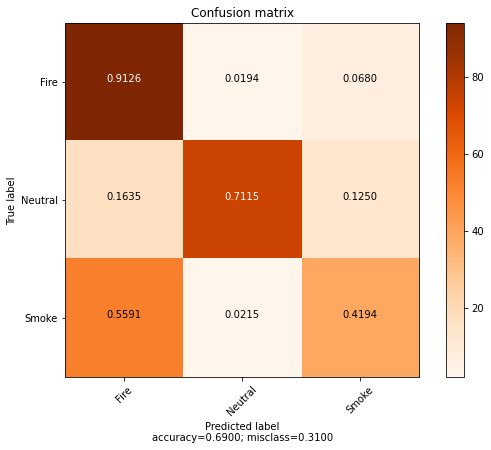

In [20]:
target_names = ['Fire', 'Neutral', 'Smoke']
plot_confusion_matrix(cmt,target_names,title='Confusion matrix',cmap=None,normalize=True)

In [21]:
# accuracy per each class
correct = { a: 0 for a in classes}
total =  { a: 0 for a in classes}
#we can use Python's with context manger keyword to specify that a specify block of code should exclude gradient computations.
with torch.no_grad():
    for images, labels in val_data_loader:
        output = model(images)
        proba, predicted = torch.max(output, dim=1)
        for label, prediction in zip(labels,predicted):
            if label == prediction :
                correct[classes[label]] +=1
            total [classes[label]]+=1
                
        
for c, k in correct.items():
   print (f'accuracy test set class {c}: {100 * k/total[c]}')

TypeError: max() received an invalid combination of arguments - got (InceptionOutputs, dim=int), but expected one of:
 * (Tensor input)
 * (Tensor input, Tensor other, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, tuple of Tensors out)
 * (Tensor input, name dim, bool keepdim, *, tuple of Tensors out)


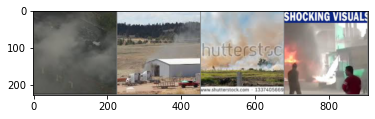

In [75]:
# display an image from the test set
dataiter = iter(test_data_loader)
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]
#print images

def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(numpy.transpose(npimg,(1,2,0)))
    plt.show()
imshow(torchvision.utils.make_grid(images))

In [73]:
#%%
print('Truth:', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Truth:  Fire Smoke  Fire  Fire


In [74]:
# dataiter = iter(train_data_loader)
# images, labels = dataiter.next()
# print(images.shape)
# classes[labels[0]]

outputs = model(images)
a , predicted = torch.max(outputs, 1)
print('Predicted:', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


Predicted:  Fire Smoke  Fire  Fire


In [ ]:
def load_checkpoint(model, optimizer,filename='model_resnet/first_model_resnet.pt'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch

model, optimizer, start_epoch = load_checkpoint(model)

                        
import copy

#model.load_state_dict(copy.deepcopy(torch.load('model_resnet/first_model_resnet.pt',device)))